✓ Files loaded successfully.

✓ Filtered to 141 entries for the year 2006

Merging data...
✓ Merge successful! Result has 141 rows

Projecting data to UTM coordinate system...

✓ Region names translated to English
Translations applied: ['Center-South' 'Northeast' 'North' 'Southeast' 'Southwest']

✓ Generating mesoregions map with inset...

✓ Map saved as 'mesoregions_map.jpg'


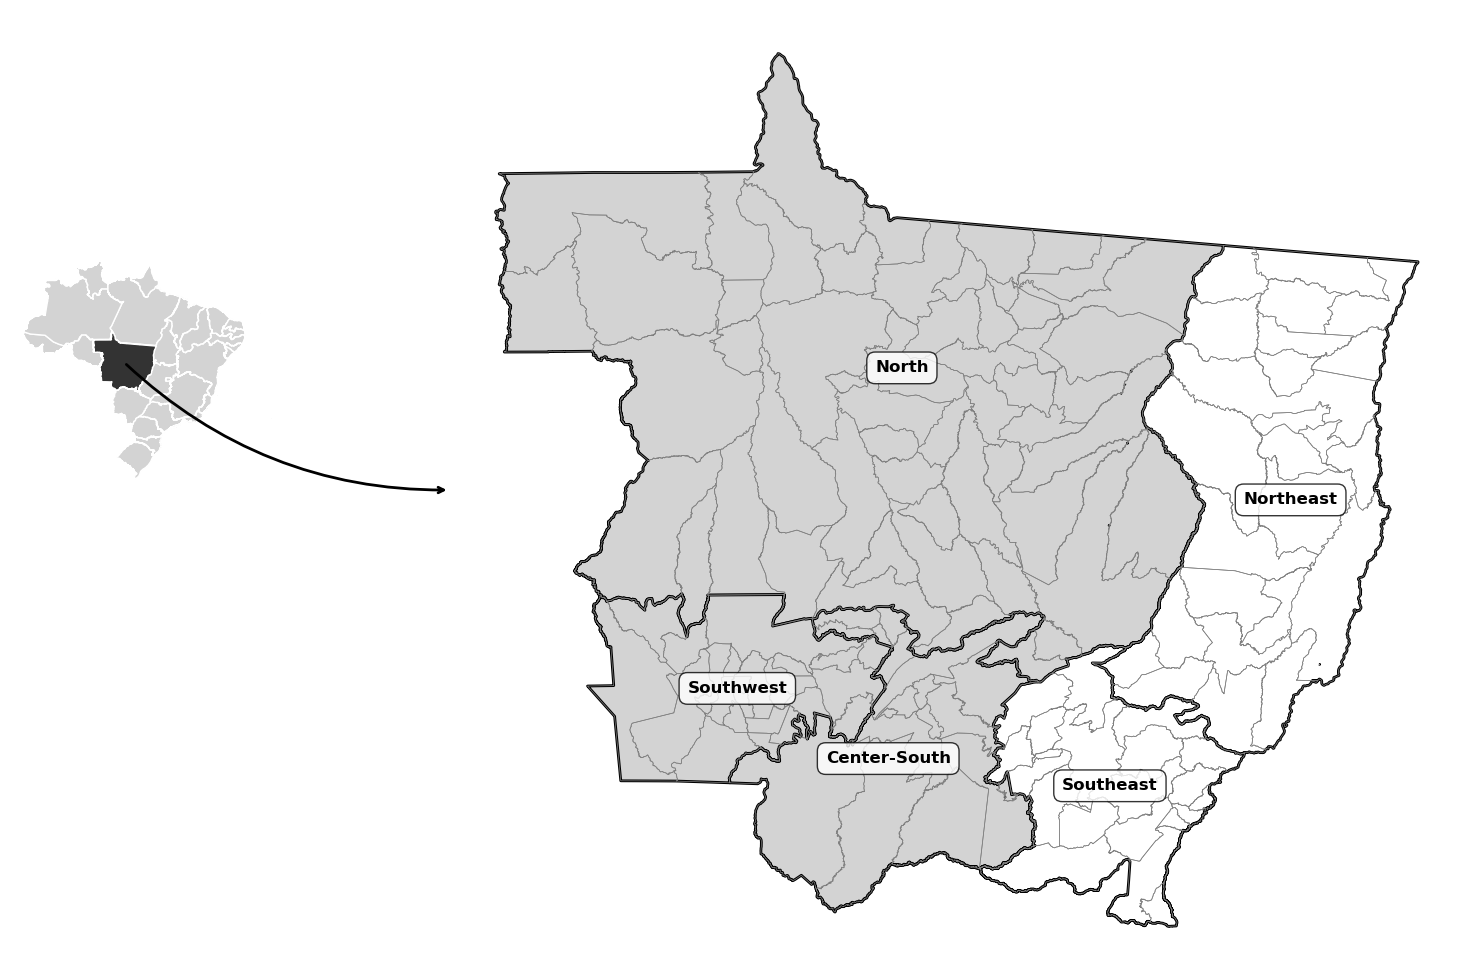

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# --- 1. Load Data ---
shapefile_path = 'MT_Municipios_2022/MT_Municipios_2022.shp'
excel_path = 'Database for regression.xlsx'
brazil_shapefile_path = 'BR_UF_2024/BR_UF_2024.shp' # Path to Brazil shapefile

gdf_mt = gpd.read_file(shapefile_path)
df_data = pd.read_excel(excel_path)
gdf_brazil = gpd.read_file(brazil_shapefile_path)
print("✓ Files loaded successfully.\n")

# --- 2. Filter for 2006 ---
if 'Ano' in df_data.columns:
    df_2006 = df_data[df_data['Ano'] == 2006].copy()
    print(f"✓ Filtered to {len(df_2006)} entries for the year 2006")
else:
    df_2006 = df_data.copy()
    print("\n⚠ 'Ano' column not found, using all data")

# --- 3. Prepare for Merge ---
gdf_mt['CD_MUN'] = gdf_mt['CD_MUN'].astype(int)
df_2006['Codigo'] = df_2006['Codigo'].astype(int)

# --- 4. Merge ---
print("\nMerging data...")
merged_gdf = gdf_mt.merge(df_2006, left_on='CD_MUN', right_on='Codigo', how='left')
print(f"✓ Merge successful! Result has {len(merged_gdf)} rows")

# --- 5. Project data to a consistent CRS ---
print("\nProjecting data to UTM coordinate system...")
target_crs = 'epsg:32721' # UTM zone 21S for Mato Grosso
merged_gdf = merged_gdf.to_crs(target_crs)
gdf_brazil = gdf_brazil.to_crs(target_crs)

# --- 6. Translate Mesorregião names to English ---
if 'Mesorregião' in merged_gdf.columns:
    merged_gdf['Mesorregião'] = merged_gdf['Mesorregião'].astype(str).str.strip()
    
    translation_dict = {
        'NORTE MATO-GROSSENSE': 'North',
        'NORDESTE MATO-GROSSENSE': 'Northeast',
        'CENTRO-SUL MATO-GROSSENSE': 'Center-South',
        'SUDESTE MATO-GROSSENSE': 'Southeast',
        'SUDOESTE MATO-GROSSENSE': 'Southwest',
        'NOROESTE MATO-GROSSENSE': 'Northwest'
    }
    
    merged_gdf['Mesorregião_EN'] = merged_gdf['Mesorregião'].map(translation_dict)
    merged_gdf['Mesorregião_EN'] = merged_gdf['Mesorregião_EN'].fillna(merged_gdf['Mesorregião'])
    
    print("\n✓ Region names translated to English")
    print(f"Translations applied: {merged_gdf['Mesorregião_EN'].unique()}")

# --- 7. Plot Mesorregião Map with Inset ---
if 'Mesorregião_EN' in merged_gdf.columns:
    print("\n✓ Generating mesoregions map with inset...")
    
    # Prepare data for main map
    meso_dissolved = merged_gdf.dissolve(by='Mesorregião_EN')
    regions_to_color_gray = ['Center-South', 'Southwest', 'North']
    meso_dissolved['plot_color'] = 'white'
    meso_dissolved.loc[meso_dissolved.index.isin(regions_to_color_gray), 'plot_color'] = 'lightgray'

    # --- Setup the Figure and Axes ---
    fig = plt.figure(figsize=(18, 12))
    # Main map axis
    ax_main = fig.add_axes([0.25, 0.1, 0.7, 0.8]) 
    # Inset map axis (Brazil)
    ax_inset = fig.add_axes([0.05, 0.5, 0.2, 0.2])

    # --- Plot the Inset Map (ax_inset) ---
    gdf_brazil.plot(ax=ax_inset, color='lightgray', edgecolor='white')
    # Highlight Mato Grosso
    gdf_mt_state = gdf_brazil[gdf_brazil['SIGLA_UF'] == 'MT']
    gdf_mt_state.plot(ax=ax_inset, color='#333333', edgecolor='white')

    # --- Plot the Main Map (ax_main) ---
    # Plot the colored, dissolved mesoregions
    meso_dissolved.plot(ax=ax_main, color=meso_dissolved['plot_color'], edgecolor='black', linewidth=2)
    # Plot the original city contours on top
    merged_gdf.plot(ax=ax_main, facecolor='none', edgecolor='gray', linewidth=0.5)

    # Add labels for each region inside a box
    for idx, row in meso_dissolved.iterrows():
        centroid = row.geometry.representative_point()
        ax_main.text(centroid.x, centroid.y, idx, fontsize=12, fontweight='bold',
                ha='center', va='center', color='black',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='black'))

    # --- Draw Connecting Arrow ---
    # Get the center point of Mato Grosso in the inset map's coordinates
    start_point = (gdf_mt_state.geometry.centroid.iloc[0].x, gdf_mt_state.geometry.centroid.iloc[0].y)
    
    # Draw an arrow from the inset's MT to the main map
    ax_inset.annotate("",
        xy=(0, 0.5), xycoords=ax_main.transAxes, # Arrow points to the middle-left of the main map
        xytext=start_point, textcoords=ax_inset.transData, # Arrow starts from MT's centroid in the inset
        arrowprops=dict(arrowstyle="->",
                        connectionstyle="arc3,rad=0.2",
                        color="black",
                        lw=2.0))

    # --- Final Touches ---
    ax_inset.set_axis_off()
    ax_main.set_axis_off()
    
    # --- Save the Figure ---
    output_filename = 'mesoregions_map.jpg'
    plt.savefig(output_filename, dpi=1200, bbox_inches='tight')
    print(f"\n✓ Map saved as '{output_filename}'")
    
    plt.show()
    
else:
    print("\n❌ 'Mesorregião' column not found after merge!")

